In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import glob
import matplotlib.pyplot as plt
import cv2
# import tensorflow.contrib.slim as slim
from sklearn.model_selection import train_test_split
from collections import Counter
%matplotlib inline

In [0]:
 #!wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
 !unzip cell_images.zip

In [0]:
parasitized_path = 'cell_images/Parasitized'
uninfected_path = 'cell_images/Uninfected'

In [0]:
parasitized_names = glob.glob(parasitized_path+"/*.png")
uninfected_names = glob.glob(uninfected_path+"/*.png")

In [8]:
np.random.seed(42)
data = pd.DataFrame({
    'filename': parasitized_names + uninfected_names,
    'label': ['malaria'] * len(parasitized_names) + ['healthy'] * len(uninfected_names)
}).sample(frac=1, random_state=42).reset_index(drop=True)

data.head()

,filename,label
0,cell_images/Parasitized/C101P62ThinF_IMG_20150...,malaria
1,cell_images/Parasitized/C129P90ThinF_IMG_20151...,malaria
2,cell_images/Uninfected/C101P62ThinF_IMG_201509...,healthy
3,cell_images/Uninfected/C234ThinF_IMG_20151112_...,healthy
4,cell_images/Uninfected/C166P127ThinF_IMG_20151...,healthy


In [9]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(data['filename'].values,
                                                                      data['label'].values, 
                                                                      test_size=0.3, random_state=42)

print(train_files.shape, test_files.shape)
print('Train:', Counter(train_labels),'\nTest:', Counter(test_labels))

(19290,) (8268,)
Train: Counter({'healthy': 9704, 'malaria': 9586}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


In [10]:
# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(test_labels)

print(train_labels[:10], train_labels_enc[:10])

['malaria' 'malaria' 'healthy' 'malaria' 'malaria' 'healthy' 'healthy'
 'malaria' 'malaria' 'malaria'] [1 1 0 1 1 0 0 1 1 1]


In [11]:
IMG_DIMS = (125, 125)

def load_resize_img(img):
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

train_data = [load_resize_img(img) for img in train_files]
test_data  = [load_resize_img(img) for img in test_files]

train_data = np.array(train_data)
test_data  = np.array(test_data)

train_data.shape, test_data.shape  

((19290, 125, 125, 3), (8268, 125, 125, 3))

In [0]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE =(125, 125,1)

In [14]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
## Generic Image Data Generator 
train_generator=ImageDataGenerator(rotation_range=20,width_shift_range=0.25,height_shift_range=0.25,shear_range=0.2,zoom_range=0.3,horizontal_flip=True,vertical_flip=True,rescale=1/255.)
test_generator=ImageDataGenerator(rescale=1/255.)

# Applying generators to training and testing images with additional parameters
train_gen=train_generator.flow(train_data ,train_labels_enc,batch_size=32,shuffle=False)
test_gen=test_generator.flow(test_data ,val_labels_enc,batch_size=1,shuffle=False)

In [19]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
batch1= tf.keras.layers.BatchNormalization()(pool1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(batch1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
batch2= tf.keras.layers.BatchNormalization()(pool2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(batch2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
batch3= tf.keras.layers.BatchNormalization()(pool3)
flat = tf.keras.layers.Flatten()(batch3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
batch4= tf.keras.layers.BatchNormalization()(hidden1)
drop1 = tf.keras.layers.Dropout(rate=0.3)(batch4)
out = tf.keras.layers.Dense(1, activation='sigmoid')(drop1)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 31, 31, 64)        256   

In [23]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)
callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_gen.n // train_gen.batch_size
val_steps_per_epoch = test_gen.n // test_gen.batch_size
results_ft = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=test_gen, validation_steps=val_steps_per_epoch, 
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
602/602 [==============================] - 85s 141ms/step - loss: 0.5690 - accuracy: 0.7403 - val_loss: 0.5284 - val_accuracy: 0.7531
Epoch 2/25
602/602 [==============================] - 85s 141ms/step - loss: 0.3155 - accuracy: 0.8796 - val_loss: 0.1773 - val_accuracy: 0.9373
Epoch 3/25
602/602 [==============================] - 85s 142ms/step - loss: 0.2795 - accuracy: 0.8967 - val_loss: 0.1574 - val_accuracy: 0.9465
Epoch 4/25
602/602 [==============================] - 85s 142ms/step - loss: 0.2616 - accuracy: 0.9054 - val_loss: 0.2301 - val_accuracy: 0.9231
Epoch 5/25
602/602 [==============================] - 86s 143ms/step - loss: 0.2557 - accuracy: 0.9073 - val_loss: 0.1627 - val_accuracy: 0.9411
Epoch 6/25
602/602 [==============================] - 86s 143ms/step - loss: 0.2395 - accuracy: 0.9140 - val_loss: 0.1688 - val_accuracy: 0.9383
Epoch 7/25
602/602 [==============================] - 

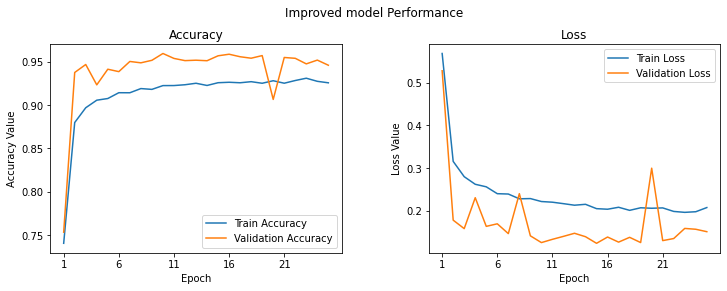

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Improved model Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(results_ft.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, results_ft.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, results_ft.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, results_ft.history['loss'], label='Train Loss')
ax2.plot(epoch_list, results_ft.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")